In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#LOAD DATA
data = pd.read_csv('Expresso_churn_dataset.csv')
data.drop(['user_id', 'REGULARITY'], axis = 1, inplace = True)
data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,TOP_PACK,FREQ_TOP_PACK,CHURN
0,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,On net 200F=Unlimited _call24H,8.0,0
1,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NaN,NaN,1
2,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,On-net 1000F=10MilF;10d,1.0,0
3,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,"Data:1000F=5GB,7d",11.0,0
4,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,Mixt 250F=Unlimited_call24H,2.0,0


In [3]:
data.shape

(2154048, 17)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154048 entries, 0 to 2154047
Data columns (total 17 columns):
 #   Column          Dtype  
---  ------          -----  
 0   REGION          object 
 1   TENURE          object 
 2   MONTANT         float64
 3   FREQUENCE_RECH  float64
 4   REVENUE         float64
 5   ARPU_SEGMENT    float64
 6   FREQUENCE       float64
 7   DATA_VOLUME     float64
 8   ON_NET          float64
 9   ORANGE          float64
 10  TIGO            float64
 11  ZONE1           float64
 12  ZONE2           float64
 13  MRG             object 
 14  TOP_PACK        object 
 15  FREQ_TOP_PACK   float64
 16  CHURN           int64  
dtypes: float64(12), int64(1), object(4)
memory usage: 279.4+ MB


In [5]:
data.isnull().sum()

REGION             849299
TENURE                  0
MONTANT            756739
FREQUENCE_RECH     756739
REVENUE            726048
ARPU_SEGMENT       726048
FREQUENCE          726048
DATA_VOLUME       1060433
ON_NET             786675
ORANGE             895248
TIGO              1290016
ZONE1             1984327
ZONE2             2017224
MRG                     0
TOP_PACK           902594
FREQ_TOP_PACK      902594
CHURN                   0
dtype: int64

In [6]:
print(f"\nMissing values per column:")
missing_data = pd.DataFrame({
    'Column': data.isnull().sum().index,
    'Missing_Count': data.isnull().sum().values,
    'Percentage': (data.isnull().sum() / len(data) * 100).values
})
print(missing_data[missing_data['Missing_Count'] > 0])


Missing values per column:
            Column  Missing_Count  Percentage
0           REGION         849299   39.428044
2          MONTANT         756739   35.131018
3   FREQUENCE_RECH         756739   35.131018
4          REVENUE         726048   33.706213
5     ARPU_SEGMENT         726048   33.706213
6        FREQUENCE         726048   33.706213
7      DATA_VOLUME        1060433   49.229776
8           ON_NET         786675   36.520774
9           ORANGE         895248   41.561191
10            TIGO        1290016   59.887988
11           ZONE1        1984327   92.120835
12           ZONE2        2017224   93.648052
14        TOP_PACK         902594   41.902223
15   FREQ_TOP_PACK         902594   41.902223


In [7]:
# Remove rows where REGION is NaN (critical identifier)
data_clean = data.dropna(subset=['REGION'])
print(f"\nRows removed due to missing REGION: {data.shape[0] - data_clean.shape[0]}")


Rows removed due to missing REGION: 849299


In [8]:
# For TENURE, fill with mode (most common tenure)
tenure_mode = data_clean['TENURE'].mode()[0]
data_clean['TENURE'].fillna(tenure_mode, inplace=True)
print(f"TENURE missing values filled with mode: {tenure_mode}")

TENURE missing values filled with mode: K > 24 month


In [9]:
# For numeric columns, fill with median
numeric_cols = data_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if data_clean[col].isnull().sum() > 0:
        median_val = data_clean[col].median()
        data_clean[col].fillna(median_val, inplace=True)
        print(f"{col} missing values filled with median: {median_val}")

MONTANT missing values filled with median: 3600.0
FREQUENCE_RECH missing values filled with median: 8.0
REVENUE missing values filled with median: 3600.0
ARPU_SEGMENT missing values filled with median: 1200.0
FREQUENCE missing values filled with median: 10.0
DATA_VOLUME missing values filled with median: 323.0
ON_NET missing values filled with median: 36.0
ORANGE missing values filled with median: 34.0
TIGO missing values filled with median: 7.0
ZONE1 missing values filled with median: 1.0
ZONE2 missing values filled with median: 1.0
FREQ_TOP_PACK missing values filled with median: 5.0


In [10]:
# For TOP_PACK and FREQ_TOP_PACK, fill with 'Unknown'
if data_clean['TOP_PACK'].isnull().sum() > 0:
    data_clean['TOP_PACK'].fillna('Unknown', inplace=True)
    print(f"TOP_PACK missing values filled with 'Unknown'")

TOP_PACK missing values filled with 'Unknown'


In [11]:
if data_clean['FREQ_TOP_PACK'].isnull().sum() > 0:
    data_clean['FREQ_TOP_PACK'].fillna(0, inplace=True)
print(f"FREQ_TOP_PACK missing values filled with 0")

FREQ_TOP_PACK missing values filled with 0


In [12]:
print(f"\nMissing values after cleaning:\n{data_clean.isnull().sum().sum()} total missing values")


Missing values after cleaning:
0 total missing values


In [13]:
#CLEAN TENURE COLUMN

print(f"\nUnique TENURE values before cleaning:")
print(data_clean['TENURE'].unique())

import re

def clean_tenure(tenure_str):
    """Extract numeric tenure value and convert to months"""
    if pd.isna(tenure_str):
        return np.nan

    tenure_str = str(tenure_str).strip().upper()

    # Extract numbers
    numbers = re.findall(r'\d+\.?\d*', tenure_str)
    if not numbers:
        return np.nan

    value = float(numbers[0])

    # Convert to months based on unit
    if 'YEAR' in tenure_str:
        return value * 12
    elif 'MONTH' in tenure_str:
        return value
    else:
        return value


Unique TENURE values before cleaning:
['K > 24 month' 'I 18-21 month' 'H 15-18 month' 'J 21-24 month'
 'F 9-12 month' 'G 12-15 month' 'D 3-6 month' 'E 6-9 month']


In [14]:
# Apply cleaning
data_clean['TENURE_months'] = data_clean['TENURE'].apply(clean_tenure)
data_clean = data_clean.drop('TENURE', axis=1)
data_clean.rename(columns={'TENURE_months': 'TENURE'}, inplace=True)

print(f"\nTENURE values after cleaning (first 10 unique):")
print(sorted(data_clean['TENURE'].unique())[:10])
print(f"\nTENURE statistics:")
print(data_clean['TENURE'].describe())


TENURE values after cleaning (first 10 unique):
[np.float64(3.0), np.float64(6.0), np.float64(9.0), np.float64(12.0), np.float64(15.0), np.float64(18.0), np.float64(21.0), np.float64(24.0)]

TENURE statistics:
count    1.304749e+06
mean     2.364459e+01
std      1.850393e+00
min      3.000000e+00
25%      2.400000e+01
50%      2.400000e+01
75%      2.400000e+01
max      2.400000e+01
Name: TENURE, dtype: float64


In [18]:
data_clean.isnull().sum()

REGION            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
MRG               0
TOP_PACK          0
FREQ_TOP_PACK     0
CHURN             0
TENURE            0
dtype: int64

In [19]:
data_clean.head()

,REGION,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,TOP_PACK,FREQ_TOP_PACK,CHURN,TENURE
0,FATICK,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,On net 200F=Unlimited _call24H,8.0,0,24.0
3,DAKAR,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,1.0,1.0,NO,"Data:1000F=5GB,7d",11.0,0,24.0
4,DAKAR,1000.0,1.0,985.0,328.0,1.0,323.0,39.0,24.0,7.0,1.0,1.0,NO,Mixt 250F=Unlimited_call24H,2.0,0,24.0
5,LOUGA,8500.0,17.0,9000.0,3000.0,18.0,323.0,252.0,70.0,91.0,1.0,1.0,NO,MIXT:500F= 2500F on net _2500F off net;2d,18.0,0,24.0
6,LOUGA,3600.0,8.0,3600.0,1200.0,10.0,323.0,36.0,34.0,7.0,1.0,1.0,NO,Unknown,5.0,0,24.0


In [20]:
data_clean.drop(['TOP_PACK'], axis=1, inplace=True)
data_clean.head()

,REGION,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,FREQ_TOP_PACK,CHURN,TENURE
0,FATICK,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,8.0,0,24.0
3,DAKAR,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,1.0,1.0,NO,11.0,0,24.0
4,DAKAR,1000.0,1.0,985.0,328.0,1.0,323.0,39.0,24.0,7.0,1.0,1.0,NO,2.0,0,24.0
5,LOUGA,8500.0,17.0,9000.0,3000.0,18.0,323.0,252.0,70.0,91.0,1.0,1.0,NO,18.0,0,24.0
6,LOUGA,3600.0,8.0,3600.0,1200.0,10.0,323.0,36.0,34.0,7.0,1.0,1.0,NO,5.0,0,24.0


In [21]:
data_clean.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK,CHURN,TENURE
count,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06,1.304749e+06
mean,5.682644e+03,1.185553e+01,5.730842e+03,1.910286e+03,1.454485e+01,2.306836e+03,2.630656e+02,8.932836e+01,1.666055e+01,1.741416e+00,1.502385e+00,8.820516e+00,1.801956e-02,2.364459e+01
std,6.819691e+03,1.273792e+01,6.946287e+03,2.315425e+03,1.413722e+01,6.809091e+03,8.475432e+02,1.919312e+02,4.959467e+01,1.344645e+01,9.158964e+00,1.139385e+01,1.330221e-01,1.850393e+00
min,1.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00
25%,1.700000e+03,4.000000e+00,1.518000e+03,5.060000e+02,5.000000e+00,4.100000e+01,8.000000e+00,1.400000e+01,6.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,2.400000e+01
50%,3.600000e+03,8.000000e+00,3.600000e+03,1.200000e+03,1.000000e+01,3.230000e+02,3.600000e+01,3.400000e+01,7.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00,2.400000e+01
75%,7.000000e+03,1.500000e+01,7.098000e+03,2.366000e+03,1.900000e+01,1.026000e+03,1.310000e+02,8.000000e+01,8.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01,0.000000e+00,2.400000e+01
max,4.700000e+05,1.330000e+02,5.321770e+05,1.773920e+05,9.100000e+01,5.103330e+05,5.080900e+04,1.204000e+04,4.174000e+03,4.792000e+03,3.143000e+03,7.130000e+02,1.000000e+00,2.400000e+01


In [22]:
num = data_clean.select_dtypes(include = ['number'])
cat = data_clean.select_dtypes(exclude = ['number'])
print('Numerical columns:')
display(num.head())
print('\nCategorical columns:')
display(cat.head())

Numerical columns:


,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,FREQ_TOP_PACK,CHURN,TENURE
0,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,8.0,0,24.0
3,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,1.0,1.0,11.0,0,24.0
4,1000.0,1.0,985.0,328.0,1.0,323.0,39.0,24.0,7.0,1.0,1.0,2.0,0,24.0
5,8500.0,17.0,9000.0,3000.0,18.0,323.0,252.0,70.0,91.0,1.0,1.0,18.0,0,24.0
6,3600.0,8.0,3600.0,1200.0,10.0,323.0,36.0,34.0,7.0,1.0,1.0,5.0,0,24.0



Categorical columns:


,REGION,MRG
0,FATICK,NO
3,DAKAR,NO
4,DAKAR,NO
5,LOUGA,NO
6,LOUGA,NO


In [23]:
#Scaling and Encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler

for i in num.columns:
  if data_clean[i].std() > 1000:
    scaler = StandardScaler()
    data_clean[i] = scaler.fit_transform(data_clean[[i]])
    joblib.dump(scaler, open(f'{i}_scaler.pkl', 'wb'))


for i in cat.columns:
  encoder = LabelEncoder()
  data_clean[i] = encoder.fit_transform(data_clean[[i]])
  joblib.dump(encoder, open(f'{i}_encoder.pkl', 'wb'))


data_clean.head()

,REGION,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,FREQ_TOP_PACK,CHURN,TENURE
0,2,-0.210075,15.0,-0.213041,-0.213043,17.0,-0.338200,388.0,46.0,1.0,1.0,2.0,0,8.0,0,24.0
3,0,1.146292,15.0,1.118750,1.118894,18.0,6.094379,41.0,102.0,2.0,1.0,1.0,0,11.0,0,24.0
4,0,-0.686636,1.0,-0.683220,-0.683368,1.0,-0.291351,39.0,24.0,7.0,1.0,1.0,0,2.0,0,24.0
5,7,0.413121,17.0,0.470634,0.470633,18.0,-0.291351,252.0,70.0,91.0,1.0,1.0,0,18.0,0,24.0
6,7,-0.305387,8.0,-0.306760,-0.306763,10.0,-0.291351,36.0,34.0,7.0,1.0,1.0,0,5.0,0,24.0


In [24]:
data['CHURN'].sample(200).values

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0])

In [30]:
sel_col = ['REGION', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT',
 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'MRG',
 'FREQ_TOP_PACK', 'TENURE', 'ZONE1', 'ZONE2', 'CHURN']
newData = data_clean[sel_col]
newData.head()

,REGION,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,MRG,FREQ_TOP_PACK,TENURE,ZONE1,ZONE2,CHURN
0,2,-0.210075,15.0,-0.213041,-0.213043,17.0,-0.338200,388.0,46.0,1.0,0,8.0,24.0,1.0,2.0,0
3,0,1.146292,15.0,1.118750,1.118894,18.0,6.094379,41.0,102.0,2.0,0,11.0,24.0,1.0,1.0,0
4,0,-0.686636,1.0,-0.683220,-0.683368,1.0,-0.291351,39.0,24.0,7.0,0,2.0,24.0,1.0,1.0,0
5,7,0.413121,17.0,0.470634,0.470633,18.0,-0.291351,252.0,70.0,91.0,0,18.0,24.0,1.0,1.0,0
6,7,-0.305387,8.0,-0.306760,-0.306763,10.0,-0.291351,36.0,34.0,7.0,0,5.0,24.0,1.0,1.0,0


In [31]:
from sklearn.model_selection import train_test_split
x = newData.drop('CHURN', axis = 1)
y = newData.CHURN

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, stratify = y)
print(f'Xtrain: {xtrain.shape}')
print(f'Xtest: {xtest.shape}')
print(f'Ytrain:{ytrain.shape}')
print(f'Ytest: {ytest.shape}')

Xtrain: (1043799, 15)
Xtest: (260950, 15)
Ytrain:(1043799,)
Ytest: (260950,)


In [32]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(xtrain, ytrain)

LogisticRegression()

In [33]:
from sklearn.metrics import classification_report
prediction = logmodel.predict(xtrain)
print(classification_report(ytrain, prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1024990
           1       0.03      0.00      0.00     18809

    accuracy                           0.98   1043799
   macro avg       0.50      0.50      0.50   1043799
weighted avg       0.96      0.98      0.97   1043799



In [34]:
prediction = logmodel.predict(xtest)
print(classification_report(ytest, prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    256248
           1       0.08      0.00      0.00      4702

    accuracy                           0.98    260950
   macro avg       0.53      0.50      0.50    260950
weighted avg       0.97      0.98      0.97    260950



<Axes: xlabel='CHURN', ylabel='count'>

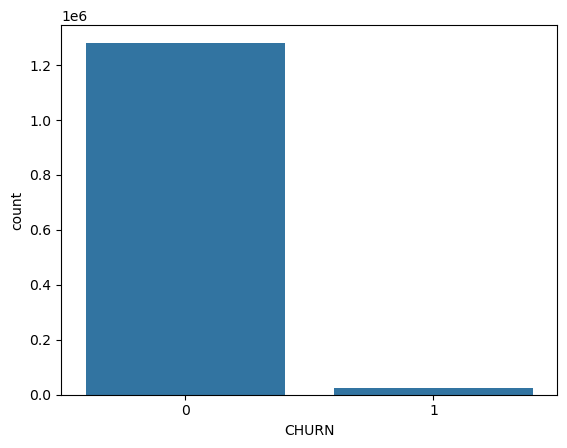

In [35]:
sns.countplot(x = data_clean.CHURN)

<Axes: xlabel='CHURN', ylabel='count'>

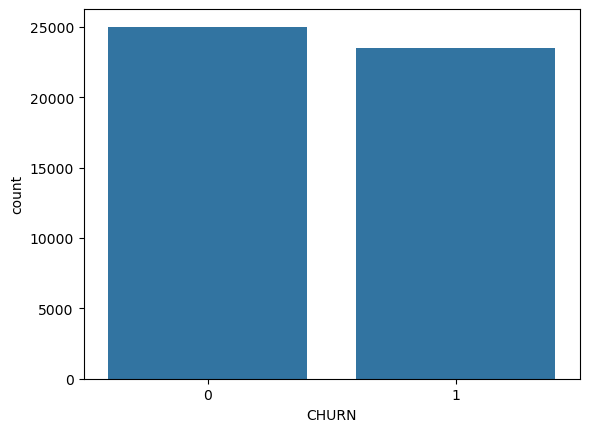

In [36]:
class0 = data_clean.loc[data['CHURN'] == 0]
class1 = data_clean.loc[data['CHURN'] == 1]

class0 = class0.sample(25000)
newData = pd.concat([class0, class1], axis = 0)

sns.countplot(x = newData.CHURN)

In [37]:
x = newData.drop('CHURN', axis = 1)
y = newData.CHURN

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, stratify = y)

In [38]:
newlogmodel = LogisticRegression()
newlogmodel.fit(xtrain, ytrain)

LogisticRegression()

In [39]:
prediction = newlogmodel.predict(xtrain)
print(classification_report(ytrain, prediction))

              precision    recall  f1-score   support

           0       0.85      0.50      0.63     20000
           1       0.63      0.91      0.75     18808

    accuracy                           0.70     38808
   macro avg       0.74      0.71      0.69     38808
weighted avg       0.75      0.70      0.69     38808



In [40]:
joblib.dump(newlogmodel, open('expresso_churn_model.pkl', 'wb'))